In [1]:
import numpy as np
import pandas as pd
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from mlxtend.classifier import StackingClassifier
from helpers import Preprocessor, ModelWorker

%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')

# Chapter IV - Fit Machine Learning Models
Perform feature engineering on the combined training & test dataset before fitting machine learning models.

In [2]:
preprocessor = Preprocessor("input/train.csv", "input/test.csv")
train_df, test_df = preprocessor.run()
print("Dimension of training data: ", train_df.shape)
print("Dimension of test data: ", test_df.shape)
train_df.head()

{'A': 36.0, 'B': 102.0, 'C': 148.0, 'D': 56.0, 'E': 121.0, 'F': 73.0, 'G': 6.0, 'T': nan, 'U': nan}
One-hot encoded columns:  Index(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Cabin', 'FamilySize', 'NormalizedFamilySize', 'IsAlone',
       'NameLength', 'NormalizedNameLength', 'HasCabin', 'Deck', 'Room',
       'NormalizedRoomNo', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'CategoricalAge_0', 'CategoricalAge_1', 'CategoricalAge_2',
       'CategoricalAge_3', 'CategoricalAge_4', 'Fare_0', 'Fare_1', 'Fare_2',
       'Fare_3', 'Embarked_0', 'Embarked_1', 'Embarked_2', 'Title_1',
       'Title_2', 'Title_3', 'Title_4', 'Title_5'],
      dtype='object')
{'A': 34.0, 'B': 78.0, 'C': 132.0, 'D': 43.0, 'E': 60.0, 'F': 63.0, 'G': 6.0, 'U': nan}
One-hot encoded columns:  Index(['PassengerId', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Cabin', 'FamilySize', 'NormalizedFamilySize', 'IsAlone', 'NameLength',
       'NormalizedNameLength', 'HasC

,Survived,Name,Sex,Age,NormalizedFamilySize,IsAlone,NormalizedNameLength,HasCabin,NormalizedRoomNo,Pclass_1,...,Fare_2,Fare_3,Embarked_0,Embarked_1,Embarked_2,Title_1,Title_2,Title_3,Title_4,Title_5
0,0,"Braund, Mr. Owen Harris",1,22.0,0.1,0,0.157143,0,0.504337,0,...,0,0,1,0,0,1,0,0,0,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,0.1,0,0.557143,1,0.574324,1,...,0,1,0,1,0,0,0,1,0,0
2,1,"Heikkinen, Miss. Laina",0,26.0,0.0,1,0.142857,0,0.504337,0,...,0,0,1,0,0,0,1,0,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,0.1,0,0.457143,1,0.831081,1,...,0,1,1,0,0,0,0,1,0,0
4,0,"Allen, Mr. William Henry",1,35.0,0.0,1,0.171429,0,0.504337,0,...,0,0,1,0,0,1,0,0,0,0


Normalize the passengers' name by removing the quotation mark

In [3]:
test_df["cleaned_name"] = test_df["Name"].apply(lambda name: name.replace('\"', ''))
ground_truth_df = pd.read_csv("input/ground-truth.csv")
ground_truth_df["cleaned_name"] = ground_truth_df["name"].apply(lambda name: name.replace('\"', ''))
test_df = pd.merge(test_df, ground_truth_df[["cleaned_name", "age", "survived"]], how="left",
                   left_on=["cleaned_name", "Age"], right_on=["cleaned_name", "age"])
test_df = test_df.rename(columns={"survived": "GroundTruth"})
test_df.head()

,Name,Sex,Age,NormalizedFamilySize,IsAlone,NormalizedNameLength,HasCabin,NormalizedRoomNo,Pclass_1,Pclass_2,...,Embarked_1,Embarked_2,Title_1,Title_2,Title_3,Title_4,Title_5,cleaned_name,age,GroundTruth
0,"Kelly, Mr. James",1,34.5,0.0,1,0.06,0,0.578825,0,0,...,0,1,1,0,0,0,0,"Kelly, Mr. James",34.5,0
1,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,0.1,0,0.38,0,0.578825,0,0,...,0,0,0,0,1,0,0,"Wilkes, Mrs. James (Ellen Needs)",47.0,1
2,"Myles, Mr. Thomas Francis",1,62.0,0.0,1,0.24,0,0.578825,0,1,...,0,1,1,0,0,0,0,"Myles, Mr. Thomas Francis",62.0,0
3,"Wirz, Mr. Albert",1,27.0,0.0,1,0.06,0,0.578825,0,0,...,0,0,1,0,0,0,0,"Wirz, Mr. Albert",27.0,0
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,0.2,0,0.62,0,0.578825,0,0,...,0,0,0,0,1,0,0,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1


Verify complete match between test data and ground truth

In [4]:
test_df[test_df["GroundTruth"].isnull()]

,Name,Sex,Age,NormalizedFamilySize,IsAlone,NormalizedNameLength,HasCabin,NormalizedRoomNo,Pclass_1,Pclass_2,...,Embarked_1,Embarked_2,Title_1,Title_2,Title_3,Title_4,Title_5,cleaned_name,age,GroundTruth


In [5]:
train_df = train_df.drop(["Name", "Age"], axis = 1)
test_df = test_df.drop(["Name", "Age", "cleaned_name", "age"], axis = 1)
print("Dimension of training data: ", train_df.shape)
print("Dimension of test data: ", test_df.shape)

features = list(train_df.columns)
features.remove('Survived')
print(features)

Dimension of training data:  (891, 27)
Dimension of test data:  (418, 27)
['Sex', 'NormalizedFamilySize', 'IsAlone', 'NormalizedNameLength', 'HasCabin', 'NormalizedRoomNo', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'CategoricalAge_0', 'CategoricalAge_1', 'CategoricalAge_2', 'CategoricalAge_3', 'CategoricalAge_4', 'Fare_0', 'Fare_1', 'Fare_2', 'Fare_3', 'Embarked_0', 'Embarked_1', 'Embarked_2', 'Title_1', 'Title_2', 'Title_3', 'Title_4', 'Title_5']


Declare universal model evaluation metrics and record best scores of each standalone model.

In [6]:
scores = ['accuracy']
model_metrics = {}

## 4.1 Logistic Regression

In [8]:
logreg_worker = ModelWorker(LogisticRegression(), scores)
logreg_worker.fit(train_df[features], train_df['Survived'],
                  test_df[features], test_df['GroundTruth'])

Fitted model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
[[206  54]
 [ 41 117]]
True positive:  117
True negative:  206
False positive:  54
False negative:  41
Accuracy = (tp + tn) / (p + n), Accuracy =  0.772727
Precision = tp / (tp + fp), Precision =  0.684211
Recall = tp / (tp + fn), Recall =  0.740506
ROC =  0.766407


In [13]:
# tuned_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# tuned_parameters = {'C': [1, 5, 10, 25, 50]}
# tuned_parameters = {'C': [3, 5, 7]}
tuned_parameters = {'C': [2, 3, 4]}
logreg_grid, best_score = logreg_worker.tune(tuned_parameters, train_df[features], train_df['Survived'],
                                             test_df[features], test_df['GroundTruth'], 5)
model_metrics["Logistic Regression"] = round(best_score["accuracy"], 6)
model_metrics

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 4}

Grid scores on development set:

0.832 (+/-0.042) for {'C': 2}
0.833 (+/-0.041) for {'C': 3}
0.834 (+/-0.044) for {'C': 4}
Elapsed time: 0.1602 seconds

[[204  56]
 [ 41 117]]
True positive:  117
True negative:  204
False positive:  56
False negative:  41
Accuracy = (tp + tn) / (p + n), Accuracy =  0.767943
Precision = tp / (tp + fp), Precision =  0.676301
Recall = tp / (tp + fn), Recall =  0.740506
ROC =  0.762561


{'Logistic Regression': 0.833895}

## 4.2 Random Forest
Fit baseline model.

In [14]:
rf_worker = ModelWorker(RandomForestClassifier(), scores)
rf_worker.fit(train_df[features], train_df['Survived'],
              test_df[features], test_df['GroundTruth'])

Fitted model:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[[202  58]
 [ 51 107]]
True positive:  107
True negative:  202
False positive:  58
False negative:  51
Accuracy = (tp + tn) / (p + n), Accuracy =  0.739234
Precision = tp / (tp + fp), Precision =  0.648485
Recall = tp / (tp + fn), Recall =  0.677215
ROC =  0.727069


Perform randomized search on model parameters

In [15]:
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

# Create the random grid
tuned_parameters = {'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
                    'max_features': ['auto', 'sqrt'],
                    'max_depth': max_depth,
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'bootstrap': [True, False]}
rf_random, best_score = rf_worker.tune(tuned_parameters, train_df[features], train_df['Survived'],
                                       test_df[features], test_df['GroundTruth'], 5, False)
model_metrics["Random Forest"] = round(best_score["accuracy"], 6)
print(model_metrics)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'n_estimators': 1800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}

Grid scores on development set:

0.813 (+/-0.065) for {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
0.815 (+/-0.057) for {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
0.822 (+/-0.040) for {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
0.824 (+/-0.042) for {'n_estimators': 1800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
0.823 (+/-0.043) for {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': 

Plot feature importance

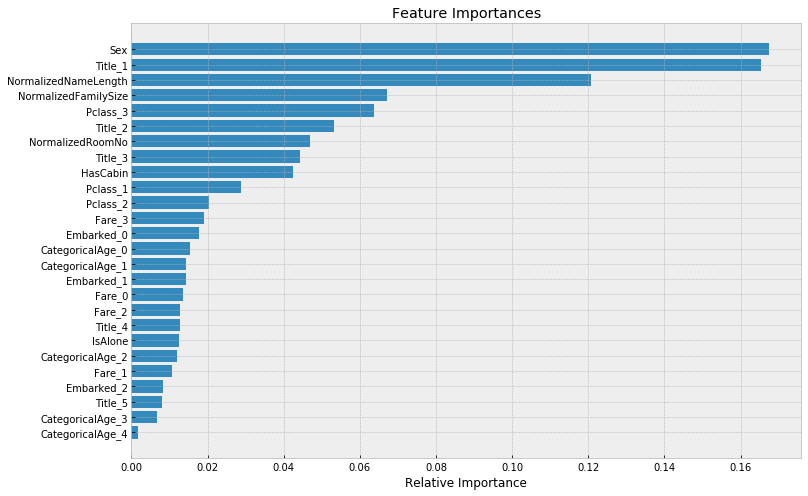

In [16]:
importances = rf_random.best_estimator_.feature_importances_
indices = np.argsort(importances)

fig = plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 4.3 Support Vector Machine

In [17]:
svm_worker = ModelWorker(SVC(gamma='auto', probability=True), scores)
svm_worker.fit(train_df[features], train_df['Survived'],
               test_df[features], test_df['GroundTruth'])

Fitted model:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
[[214  46]
 [ 45 113]]
True positive:  113
True negative:  214
False positive:  46
False negative:  45
Accuracy = (tp + tn) / (p + n), Accuracy =  0.782297
Precision = tp / (tp + fp), Precision =  0.710692
Recall = tp / (tp + fn), Recall =  0.71519
ROC =  0.769133


In [23]:
# Set the parameters by cross-validation
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1],
#                      'C': [0.001, 0.01, 0.1, 1, 10]},
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.01, 0.05, 0.1, 0.5, 1],
#                      'C': [0.1, 0.5, 1, 5, 10]},
#                     {'kernel': ['linear'], 'C': [1]}]
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.03, 0.05, 0.07],
#                      'C': [3, 5, 7]},
#                     {'kernel': ['linear'], 'C': [1]}]
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.02, 0.03, 0.04],
                     'C': [2, 3, 4, 5]},
                    {'kernel': ['linear'], 'C': [1]}]
svm_grid, best_score = svm_worker.tune(tuned_parameters, train_df[features], train_df['Survived'],
                                       test_df[features], test_df['GroundTruth'], 5)
model_metrics["SVM"] = round(best_score["accuracy"], 6)
print(model_metrics)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 4, 'gamma': 0.03, 'kernel': 'rbf'}

Grid scores on development set:

0.795 (+/-0.049) for {'C': 2, 'gamma': 0.02, 'kernel': 'rbf'}
0.810 (+/-0.043) for {'C': 2, 'gamma': 0.03, 'kernel': 'rbf'}
0.827 (+/-0.036) for {'C': 2, 'gamma': 0.04, 'kernel': 'rbf'}
0.801 (+/-0.045) for {'C': 3, 'gamma': 0.02, 'kernel': 'rbf'}
0.827 (+/-0.036) for {'C': 3, 'gamma': 0.03, 'kernel': 'rbf'}
0.826 (+/-0.040) for {'C': 3, 'gamma': 0.04, 'kernel': 'rbf'}
0.815 (+/-0.037) for {'C': 4, 'gamma': 0.02, 'kernel': 'rbf'}
0.829 (+/-0.037) for {'C': 4, 'gamma': 0.03, 'kernel': 'rbf'}
0.824 (+/-0.045) for {'C': 4, 'gamma': 0.04, 'kernel': 'rbf'}
0.823 (+/-0.034) for {'C': 5, 'gamma': 0.02, 'kernel': 'rbf'}
0.826 (+/-0.040) for {'C': 5, 'gamma': 0.03, 'kernel': 'rbf'}
0.822 (+/-0.042) for {'C': 5, 'gamma': 0.04, 'kernel': 'rbf'}
0.827 (+/-0.041) for {'C': 1, 'kernel': 'linear'}
Elapsed time: 7.507 seconds

[[212  48]
 [ 4

## 4.4 XGBoost
### 4.4.1 Build a baseline model with fix learning rate and number of estimators.

In [24]:
survival_xgb = XGBClassifier(learning_rate=0.1,
                             n_estimators=1000,
                             max_depth=5,
                             min_child_weight=1,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'binary:logistic',
                             nthread=4,
                             scale_pos_weight=1,
                             seed=27)
xgb_worker = ModelWorker(survival_xgb, scores)
xgb_worker.fit(train_df[features], train_df['Survived'],
               test_df[features], test_df['GroundTruth'])

Fitted model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=4,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
              subsample=0.8)
[[199  61]
 [ 44 114]]
True positive:  114
True negative:  199
False positive:  61
False negative:  44
Accuracy = (tp + tn) / (p + n), Accuracy =  0.748804
Precision = tp / (tp + fp), Precision =  0.651429
Recall = tp / (tp + fn), Recall =  0.721519
ROC =  0.743452


### General approach of tuning XGBoost parameters
<ol>
    <li>Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.</li>
    <li>Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.</li>
    <li>Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.</li>
    <li>Lower the learning rate and decide the optimal parameters.</li>
</ol>

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
### 4.4.2 Tune max_depth and min_child_weight

In [26]:
# tuned_parameters = {
#     "max_depth"        : range(3, 10, 2),
#     "min_child_weight" : range(1, 6, 2)
# }
tuned_parameters = {
    "max_depth"        : [6, 7, 8],
    "min_child_weight" : [2, 3, 4]
}
model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=140,
                          max_depth=5,
                          min_child_weight=1,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective='binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          seed=27)
xgb_worker = ModelWorker(model_xgb, scores)
xgb_grid, best_score = xgb_worker.tune(tuned_parameters, train_df[features], train_df['Survived'],
                                       test_df[features], test_df['GroundTruth'], 5)
model_metrics["XGBoost"] = round(best_score["accuracy"], 6)
print(model_metrics)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'max_depth': 7, 'min_child_weight': 3}

Grid scores on development set:

0.823 (+/-0.026) for {'max_depth': 6, 'min_child_weight': 2}
0.825 (+/-0.036) for {'max_depth': 6, 'min_child_weight': 3}
0.818 (+/-0.025) for {'max_depth': 6, 'min_child_weight': 4}
0.822 (+/-0.032) for {'max_depth': 7, 'min_child_weight': 2}
0.829 (+/-0.035) for {'max_depth': 7, 'min_child_weight': 3}
0.817 (+/-0.035) for {'max_depth': 7, 'min_child_weight': 4}
0.811 (+/-0.041) for {'max_depth': 8, 'min_child_weight': 2}
0.827 (+/-0.040) for {'max_depth': 8, 'min_child_weight': 3}
0.815 (+/-0.039) for {'max_depth': 8, 'min_child_weight': 4}
Elapsed time: 9.933 seconds

[[203  57]
 [ 41 117]]
True positive:  117
True negative:  203
False positive:  57
False negative:  41
Accuracy = (tp + tn) / (p + n), Accuracy =  0.76555
Precision = tp / (tp + fp), Precision =  0.672414
Recall = tp / (tp + fn), Recall =  0.740506
ROC =  0.760

### 4.4.3 Tune gamma

In [27]:
tuned_parameters = {
    "gamma"        : [i/10.0 for i in range(0, 5)]
}
model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=140,
                          max_depth=7,
                          min_child_weight=3,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective='binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          seed=27)
xgb_worker = ModelWorker(model_xgb, scores)
xgb_grid, best_score = xgb_worker.tune(tuned_parameters, train_df[features], train_df['Survived'],
                                       test_df[features], test_df['GroundTruth'], 5)
model_metrics["XGBoost"] = round(best_score["accuracy"], 6)
print(model_metrics)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'gamma': 0.0}

Grid scores on development set:

0.829 (+/-0.035) for {'gamma': 0.0}
0.825 (+/-0.031) for {'gamma': 0.1}
0.824 (+/-0.022) for {'gamma': 0.2}
0.824 (+/-0.039) for {'gamma': 0.3}
0.819 (+/-0.031) for {'gamma': 0.4}
Elapsed time: 5.7129 seconds

[[203  57]
 [ 41 117]]
True positive:  117
True negative:  203
False positive:  57
False negative:  41
Accuracy = (tp + tn) / (p + n), Accuracy =  0.76555
Precision = tp / (tp + fp), Precision =  0.672414
Recall = tp / (tp + fn), Recall =  0.740506
ROC =  0.760638
{'Logistic Regression': 0.833895, 'Random Forest': 0.823793, 'SVM': 0.829405, 'XGBoost': 0.829405}


### 4.4.4 Tune subsample and colsample_bytree

In [29]:
# tuned_parameters = {
#     "subsample"        : [i/10.0 for i in range(6, 10)],
#     "colsample_bytree" : [i/10.0 for i in range(6, 10)]
# }
tuned_parameters = {
    "subsample"        : [i/100.0 for i in range(70, 90, 5)],
    "colsample_bytree" : [i/100.0 for i in range(70, 90, 5)]
}
model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=140,
                          max_depth=7,
                          min_child_weight=3,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective='binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          seed=27)
xgb_worker = ModelWorker(model_xgb, scores)
xgb_grid, best_score = xgb_worker.tune(tuned_parameters, train_df[features], train_df['Survived'],
                                       test_df[features], test_df['GroundTruth'], 5)
model_metrics["XGBoost"] = round(best_score["accuracy"], 6)
print(model_metrics)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'colsample_bytree': 0.8, 'subsample': 0.8}

Grid scores on development set:

0.823 (+/-0.037) for {'colsample_bytree': 0.7, 'subsample': 0.7}
0.817 (+/-0.030) for {'colsample_bytree': 0.7, 'subsample': 0.75}
0.818 (+/-0.043) for {'colsample_bytree': 0.7, 'subsample': 0.8}
0.819 (+/-0.048) for {'colsample_bytree': 0.7, 'subsample': 0.85}
0.816 (+/-0.040) for {'colsample_bytree': 0.75, 'subsample': 0.7}
0.814 (+/-0.036) for {'colsample_bytree': 0.75, 'subsample': 0.75}
0.818 (+/-0.045) for {'colsample_bytree': 0.75, 'subsample': 0.8}
0.815 (+/-0.047) for {'colsample_bytree': 0.75, 'subsample': 0.85}
0.818 (+/-0.029) for {'colsample_bytree': 0.8, 'subsample': 0.7}
0.813 (+/-0.033) for {'colsample_bytree': 0.8, 'subsample': 0.75}
0.829 (+/-0.035) for {'colsample_bytree': 0.8, 'subsample': 0.8}
0.820 (+/-0.044) for {'colsample_bytree': 0.8, 'subsample': 0.85}
0.826 (+/-0.027) for {'colsample_bytree': 0.8

### 4.4.5 Tune Regularization Parameters

In [35]:
# tuned_parameters = {
#     "reg_alpha" : [1e-5, 1e-2, 0.1, 1, 100],
#     "reg_lambda" : [1e-5, 1e-2, 0.1, 1, 100],
# }
# tuned_parameters = {
#     "reg_alpha" : [0, 1e-5, 1e-4, 1e-3],
#     "reg_lambda" : [0.5, 1, 2, 3],
# }
tuned_parameters = {
    "reg_alpha" : [5e-4, 1e-3, 5e-3],
    "reg_lambda" : [0.8, 1, 1.2],
}
model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=140,
                          max_depth=7,
                          min_child_weight=3,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective='binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          seed=27)
xgb_worker = ModelWorker(model_xgb, scores)
xgb_grid, best_score = xgb_worker.tune(tuned_parameters, train_df[features], train_df['Survived'],
                                       test_df[features], test_df['GroundTruth'], 5)
model_metrics["XGBoost"] = round(best_score["accuracy"], 6)
print(model_metrics)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'reg_alpha': 0.0005, 'reg_lambda': 1}

Grid scores on development set:

0.823 (+/-0.035) for {'reg_alpha': 0.0005, 'reg_lambda': 0.8}
0.832 (+/-0.028) for {'reg_alpha': 0.0005, 'reg_lambda': 1}
0.819 (+/-0.031) for {'reg_alpha': 0.0005, 'reg_lambda': 1.2}
0.824 (+/-0.043) for {'reg_alpha': 0.001, 'reg_lambda': 0.8}
0.832 (+/-0.028) for {'reg_alpha': 0.001, 'reg_lambda': 1}
0.819 (+/-0.031) for {'reg_alpha': 0.001, 'reg_lambda': 1.2}
0.823 (+/-0.037) for {'reg_alpha': 0.005, 'reg_lambda': 0.8}
0.824 (+/-0.032) for {'reg_alpha': 0.005, 'reg_lambda': 1}
0.827 (+/-0.031) for {'reg_alpha': 0.005, 'reg_lambda': 1.2}
Elapsed time: 10.7235 seconds

[[203  57]
 [ 41 117]]
True positive:  117
True negative:  203
False positive:  57
False negative:  41
Accuracy = (tp + tn) / (p + n), Accuracy =  0.76555
Precision = tp / (tp + fp), Precision =  0.672414
Recall = tp / (tp + fn), Recall =  0.740506
ROC =  0.76063

### 4.4.6 Reduce learning rate

In [39]:
# tuned_parameters = {
#     "learning_rate": [0.1, 0.01],
#     "n_estimators" : [100, 200, 500, 1000, 2000]
# }
# tuned_parameters = {
#     "learning_rate": [0.5, 0.1, 0.05, 0.01],
#     "n_estimators" : [100, 200, 300, 500]
# }
tuned_parameters = {
    "learning_rate": [0.03, 0.05, 0.07],
    "n_estimators" : [150, 300, 400]
}
# tuned_parameters = {
#     "learning_rate": [0.08, 0.09, 0.1, 0.11],
#     "n_estimators" : [100, 125, 150]
# }
model_xgb = XGBClassifier(learning_rate=0.01,
                          n_estimators=5000,
                          max_depth=7,
                          min_child_weight=3,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective='binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          reg_alpha=0.0005,
                          reg_lambda=1,
                          seed=27)
xgb_worker = ModelWorker(model_xgb, scores)
xgb_grid, best_score = xgb_worker.tune(tuned_parameters, train_df[features], train_df['Survived'],
                                       test_df[features], test_df['GroundTruth'], 5)
model_metrics["XGBoost"] = round(best_score["accuracy"], 6)
print(model_metrics)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'learning_rate': 0.05, 'n_estimators': 300}

Grid scores on development set:

0.817 (+/-0.039) for {'learning_rate': 0.03, 'n_estimators': 150}
0.822 (+/-0.025) for {'learning_rate': 0.03, 'n_estimators': 300}
0.826 (+/-0.022) for {'learning_rate': 0.03, 'n_estimators': 400}
0.819 (+/-0.018) for {'learning_rate': 0.05, 'n_estimators': 150}
0.827 (+/-0.024) for {'learning_rate': 0.05, 'n_estimators': 300}
0.822 (+/-0.042) for {'learning_rate': 0.05, 'n_estimators': 400}
0.826 (+/-0.034) for {'learning_rate': 0.07, 'n_estimators': 150}
0.823 (+/-0.047) for {'learning_rate': 0.07, 'n_estimators': 300}
0.823 (+/-0.047) for {'learning_rate': 0.07, 'n_estimators': 400}
Elapsed time: 16.0659 seconds

[[202  58]
 [ 44 114]]
True positive:  114
True negative:  202
False positive:  58
False negative:  44
Accuracy = (tp + tn) / (p + n), Accuracy =  0.755981
Precision = tp / (tp + fp), Precision =  0.662791
Rec

## 4.5 LightGBM
Take note that CatBoost cannot be used on one-hot encoded dataset. LightGBM is applied in this case.
### 4.5.1 Fit a baseline model

In [40]:
lgb_worker = ModelWorker(LGBMClassifier(), scores)
lgb_worker.fit(train_df[features], train_df['Survived'],
               test_df[features], test_df['GroundTruth'])

Fitted model:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
[[194  66]
 [ 36 122]]
True positive:  122
True negative:  194
False positive:  66
False negative:  36
Accuracy = (tp + tn) / (p + n), Accuracy =  0.755981
Precision = tp / (tp + fp), Precision =  0.648936
Recall = tp / (tp + fn), Recall =  0.772152
ROC =  0.759153


### 4.5.2 Tune tree-specific parameters 

In [44]:
tuned_parameters = {
    "num_leaves": [int(x) for x in np.linspace(5, 55, num=6)], 
    "min_child_samples": [3, 5, 10, 15, 20], 
    "min_child_weight": range(1, 6, 2),
    "subsample": [i/10.0 for i in range(6, 10)], 
    "colsample_bytree": [i/10.0 for i in range(6, 10)],
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 100],
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 100]
}
lgb_worker = ModelWorker(LGBMClassifier(learning_rate=0.1, n_estimators=100, seed=27), scores)
lgb_random, best_score = lgb_worker.tune(tuned_parameters, train_df[features], train_df['Survived'],
                                       test_df[features], test_df['GroundTruth'], 5, False)
model_metrics["LightGBM"] = round(best_score["accuracy"], 6)
print(model_metrics)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 1, 'num_leaves': 5, 'min_child_weight': 1, 'min_child_samples': 5, 'colsample_bytree': 0.6}

Grid scores on development set:

0.829 (+/-0.040) for {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 1, 'num_leaves': 5, 'min_child_weight': 1, 'min_child_samples': 5, 'colsample_bytree': 0.6}
0.829 (+/-0.033) for {'subsample': 0.9, 'reg_lambda': 0.01, 'reg_alpha': 1, 'num_leaves': 15, 'min_child_weight': 3, 'min_child_samples': 20, 'colsample_bytree': 0.7}
0.825 (+/-0.032) for {'subsample': 0.7, 'reg_lambda': 100, 'reg_alpha': 1, 'num_leaves': 15, 'min_child_weight': 1, 'min_child_samples': 3, 'colsample_bytree': 0.7}
0.816 (+/-0.018) for {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.01, 'num_leaves': 25, 'min_child_weight': 3, 'min_child_samples': 5, 'colsample_bytree': 0.9}
0.814 (+/-0.021) for {'subsample': 0.7, 'reg_lambda': 0.01, 'reg_alpha': 0.1

### 4.5.3 Search for optimal pair of learning_rate & n_estimators

In [47]:
# tuned_parameters = {
#     "learning_rate": [0.01, 0.05, 0.1, 0.2],
#     "n_estimators" : [100, 500, 1000]
# }
# tuned_parameters = {
#     "learning_rate": [0.005, 0.01, 0.02],
#     "n_estimators" : [250, 500, 750]
# }
tuned_parameters = {
    "learning_rate": [0.008, 0.01, 0.012, 0.015],
    "n_estimators" : [600, 750, 800, 900]
}
model_lgb = LGBMClassifier(learning_rate=0.1,
                           n_estimators=100,
                           subsample=0.9,
                           reg_lambda=1,
                           reg_alpha=1,
                           num_leaves=5,
                           min_child_weight=1,
                           min_child_samples=5,
                           colsample_bytree=0.6,
                           seed=27)
lgb_worker = ModelWorker(model_lgb, scores)
lgb_grid, best_score = lgb_worker.tune(tuned_parameters, train_df[features], train_df['Survived'],
                                       test_df[features], test_df['GroundTruth'], 5)
model_metrics["LightGBM"] = round(best_score["accuracy"], 6)
print(model_metrics)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'learning_rate': 0.008, 'n_estimators': 900}

Grid scores on development set:

0.828 (+/-0.039) for {'learning_rate': 0.008, 'n_estimators': 600}
0.832 (+/-0.042) for {'learning_rate': 0.008, 'n_estimators': 750}
0.832 (+/-0.042) for {'learning_rate': 0.008, 'n_estimators': 800}
0.833 (+/-0.045) for {'learning_rate': 0.008, 'n_estimators': 900}
0.832 (+/-0.042) for {'learning_rate': 0.01, 'n_estimators': 600}
0.832 (+/-0.047) for {'learning_rate': 0.01, 'n_estimators': 750}
0.833 (+/-0.046) for {'learning_rate': 0.01, 'n_estimators': 800}
0.828 (+/-0.052) for {'learning_rate': 0.01, 'n_estimators': 900}
0.832 (+/-0.043) for {'learning_rate': 0.012, 'n_estimators': 600}
0.829 (+/-0.051) for {'learning_rate': 0.012, 'n_estimators': 750}
0.829 (+/-0.048) for {'learning_rate': 0.012, 'n_estimators': 800}
0.825 (+/-0.045) for {'learning_rate': 0.012, 'n_estimators': 900}
0.826 (+/-0.043) for {'learning_r

Plot feature importance graph.

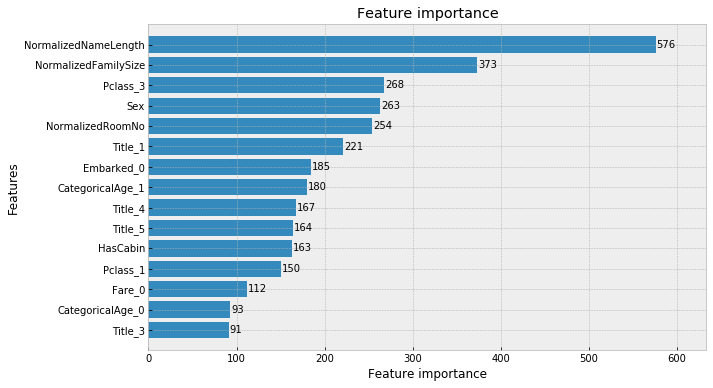

In [48]:
ax = lgb.plot_importance(lgb_grid.best_estimator_, height=0.8, max_num_features=15, figsize=(10,6))
plt.show()

## 4.6 Build Ensemble Model
### 4.6.1 Compare performance of level-1 classifiers.

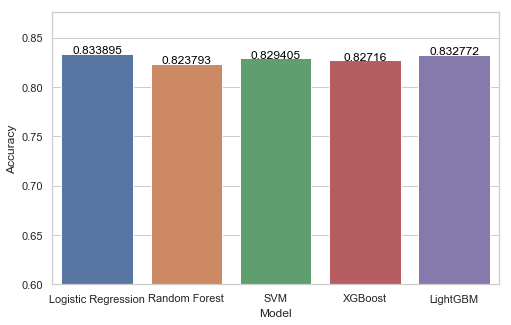

In [49]:
model_metrics_df = pd.DataFrame(list(model_metrics.items()), columns=["Model", "Accuracy"])
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")
g = sns.barplot(x="Model", y="Accuracy", data=model_metrics_df)
g.set(ylim=(0.6, None))
for index, row in model_metrics_df.iterrows():
    g.text(row.name, row.Accuracy, round(row.Accuracy, 6), color='black', ha="center")

### 4.6.2 Fit Stacking Classifier
The performance is not as good as expected. The resulting accuracy is lower than the best fitted model.

In [51]:
start_time = time.time()
clf1 = logreg_grid.best_estimator_
clf2 = rf_random.best_estimator_
clf3 = svm_grid.best_estimator_
clf4 = xgb_grid.best_estimator_
clf5 = lgb_grid.best_estimator_
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3, clf4, clf5],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=LogisticRegression())
# params = {'meta_classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
params = {'meta_classifier__C': [0.005, 0.01, 0.02, 0.05]}
grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(train_df[features], train_df['Survived'])
cv_keys = ('mean_test_score', 'std_test_score', 'params')
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.6f +/- %0.6f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.6f' % grid.best_score_)
print("Elapsed time: %s seconds" % round(time.time() - start_time, 4))

0.824916 +/- 0.012006 {'meta_classifier__C': 0.005}
0.826038 +/- 0.010887 {'meta_classifier__C': 0.01}
0.827160 +/- 0.009689 {'meta_classifier__C': 0.02}
0.827160 +/- 0.007581 {'meta_classifier__C': 0.05}
Best parameters: {'meta_classifier__C': 0.02}
Accuracy: 0.827160
Elapsed time: 85.8344 seconds


### 4.6.3 Apply feature weighted linear stacking
Collect predicted probability of survival from standalone models.

In [60]:
prediction_df = pd.DataFrame(columns=['logreg', 'rf', 'svm', 'xgb', 'lgb'])
prediction_df['logreg'] = clf1.predict_proba(train_df[features])[:,1]
prediction_df['rf'] = clf2.predict_proba(train_df[features])[:,1]
prediction_df['svm'] = clf3.predict_proba(train_df[features])[:,1]
prediction_df['xgb'] = clf4.predict_proba(train_df[features])[:,1]
prediction_df['lgb'] = clf5.predict_proba(train_df[features])[:,1]
print("Shape: ", prediction_df.shape)
prediction_df.head()

Shape:  (891, 5)


,logreg,rf,svm,xgb,lgb
0,0.051782,0.122288,0.123576,0.117878,0.101282
1,0.975197,0.997046,0.937520,0.996164,0.963772
2,0.629324,0.506329,0.664326,0.676615,0.527071
3,0.941086,0.993599,0.881495,0.977795,0.939800
4,0.063481,0.121430,0.128682,0.141132,0.098738


In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

y_prob = cross_val_predict(LinearRegression(), train_df[features], train_df['Survived'], cv=5)
y_pred = np.array([1 if p > 0.5 else 0 for p in y_prob])
accuracy_score(y_pred, train_df['Survived'].values)

0.8316498316498316